# Textual Emotion Recognition

1. Traditional ML models
- Need more preprocessing steps like stopwords/punctuation removal, stemming, tokenizing, etc...
2. Deep Learning models
- Slightly less preprocessing steps, but performance and train/inferece time tend to improve.
3. LLM Agents
- Preferable with raw text. LLMs are trained with different tokenization techniques that handle different word formations, replacing stemming step (for example).

In [3]:
!pip install wordcloud nltk beautifulsoup4 spacy textblob
!python -m spacy download en_core_web_sm
# Import data science libraries
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import LabelBinarizer
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, mean_squared_error, confusion_matrix

from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from wordcloud import WordCloud,STOPWORDS
from nltk.stem import LancasterStemmer, WordNetLemmatizer
from nltk.tokenize import word_tokenize, sent_tokenize

import spacy
import re
import string
import unicodedata

from textblob import TextBlob
from textblob import Word

from bs4 import BeautifulSoup

nltk.download('stopwords')
nltk.download('punkt')

from nltk.corpus.reader.tagged import ToktokTokenizer
tokenizers = ToktokTokenizer()
stopwords = nltk.corpus.stopwords.words('english')

def noiseremovel_text(text):
  soup = BeautifulSoup(text, "html.parser")
  text = soup.get_text()
  text = re.sub('\[[^]]*\]', '',text)
  return text

def stemmer(text):
  ps = nltk.porter.PorterStemmer()
  text = '.'.join([ps.stem(word) for word in text.split()])
  return text

  Using cached wordcloud-1.9.4-cp38-cp38-macosx_10_9_x86_64.whl.metadata (3.4 kB)
  Using cached nltk-3.9.1-py3-none-any.whl.metadata (2.9 kB)
  Using cached spacy-3.8.2.tar.gz (1.3 MB)
  Installing build dependencies ... error
  error: subprocess-exited-with-error
  
  × pip subprocess to install build dependencies did not run successfully.
  │ exit code: 1
  ╰─> [92 lines of output]
      Ignoring numpy: markers 'python_version >= "3.9"' don't match your environment
        Using cached setuptools-75.3.2-py3-none-any.whl.metadata (6.9 kB)
        Using cached Cython-0.29.37-py2.py3-none-any.whl.metadata (3.1 kB)
        Using cached cymem-2.0.11.tar.gz (10 kB)
        Installing build dependencies: started
        Installing build dependencies: finished with status 'done'
        Getting requirements to build wheel: started
        Getting requirements to build wheel: finished with status 'done'
        Preparing metadata (pyproject.toml): started
        Preparing metadata (pyprojec

ModuleNotFoundError: No module named 'nltk'

## Datasets
1. "Emotion Dataset for Emotion Recognition Task" is a dataset of English Twitter messages with six basic emotions: anger, fear, joy, love, sadness, and surprise. From: https://github.com/dair-ai/
Download: https://www.kaggle.com/datasets/parulpandey/emotion-dataset emotion\_dataset
2. "Emotion Analysis Based on Text" includes texts labeled with the emotions: neutral, love, happiness, sadness and relief. 
Download: https://www.kaggle.com/datasets/simaanjali/emotion-analysis-based-on-text
3. "Emotions" is a collection of English Twitter messages meticulously annotated with six fundamental emotions: anger, fear, joy, love, sadness, and surprise. 
Download: https://www.kaggle.com/datasets/nelgiriyewithana/emotions/data

In [1]:
import kagglehub
import pandas as pd
import os
import sys
module_path = os.path.abspath(os.path.join('..', '..')) # or the path to your source code
sys.path.insert(0, module_path)
from src.recognizers import TextEmotionRecognizer

# Download the dataset
file_path = kagglehub.dataset_download('parulpandey/emotion-dataset')
print(os.listdir(file_path))
# Load the dataset
df = pd.concat([pd.read_csv(file_path + '/validation.csv'), 
               #pd.read_csv(file_path + '/training.csv'), 
               pd.read_csv(file_path + '/test.csv')])

df.info()

/Users/sofiafernandes/miniconda3/envs/varm/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-07-15 17:14:30.793133: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


['validation.csv', 'training.csv', 'test.csv']
<class 'pandas.core.frame.DataFrame'>
Index: 4000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    4000 non-null   object
 1   label   4000 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 93.8+ KB


In [2]:
emotions_map = {
    0: 'sad',
    1: 'happy',
    2: 'happy',
    3: 'angry',
    4: 'fear'
}

df['emotion'] = df['label'].map(emotions_map)
df.head

<bound method NDFrame.head of                                                    text  label emotion
0     im feeling quite sad and sorry for myself but ...      0     sad
1     i feel like i am still looking at a blank canv...      0     sad
2                        i feel like a faithful servant      2   happy
3                     i am just feeling cranky and blue      3   angry
4     i can have for a treat or if i am feeling festive      1   happy
...                                                 ...    ...     ...
1995  i just keep feeling like someone is being unki...      3   angry
1996  im feeling a little cranky negative after this...      3   angry
1997  i feel that i am useful to my people and that ...      1   happy
1998  im feeling more comfortable with derby i feel ...      1   happy
1999  i feel all weird when i have to meet w people ...      4    fear

[4000 rows x 3 columns]>

In [16]:
from tqdm import tqdm
tqdm.pandas(desc="Processing text data")

df_sample = df.sample(150, random_state=42)  # Sample 1000 rows for testing
recognizer = TextEmotionRecognizer("qwen")
# Analyze the text data
df_sample['predicted_emotion'] = df_sample['text'].progress_apply(lambda x: recognizer.analyze(x))

# phi4-mini 6min
# tinyllama 3min30s
# orca-mini 10min
# qwen

Processing text data: 100%|██████████| 150/150 [08:31<00:00,  3.41s/it]


In [18]:
df_sample.isna()

,text,label,emotion,predicted_emotion
555,False,False,False,False
1491,False,False,False,False
527,False,False,False,False
1925,False,False,True,False
989,False,False,False,False
...,...,...,...,...
490,False,False,False,False
499,False,False,False,False
1003,False,False,True,False
114,False,False,False,False


In [19]:
df_sample.dropna(inplace=True)

In [20]:
df_sample.info()

<class 'pandas.core.frame.DataFrame'>
Index: 143 entries, 555 to 1484
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   text               143 non-null    object
 1   label              143 non-null    int64 
 2   emotion            143 non-null    object
 3   predicted_emotion  143 non-null    object
dtypes: int64(1), object(3)
memory usage: 5.6+ KB


### phy4-mini

              precision    recall  f1-score   support

  aggressive       0.00      0.00      0.00         0
       anger       0.00      0.00      0.00         0
       angry       0.65      0.59      0.62        22
     annoyed       0.00      0.00      0.00         0
    confused       0.00      0.00      0.00         0
     curious       0.00      0.00      0.00         0
     disgust       0.00      0.00      0.00         0
        fear       0.60      0.40      0.48        15
   happiness       0.00      0.00      0.00         0
       happy       0.88      0.48      0.62        60
     neutral       0.00      0.00      0.00         0
       panic       0.00      0.00      0.00         0
       pride       0.00      0.00      0.00         0
  protective       0.00      0.00      0.00         0
         sad       0.67      0.63      0.65        46
    surprise       0.00      0.00      0.00         0
   surprised       0.00      0.00      0.00         0
   uncertain       0.00    

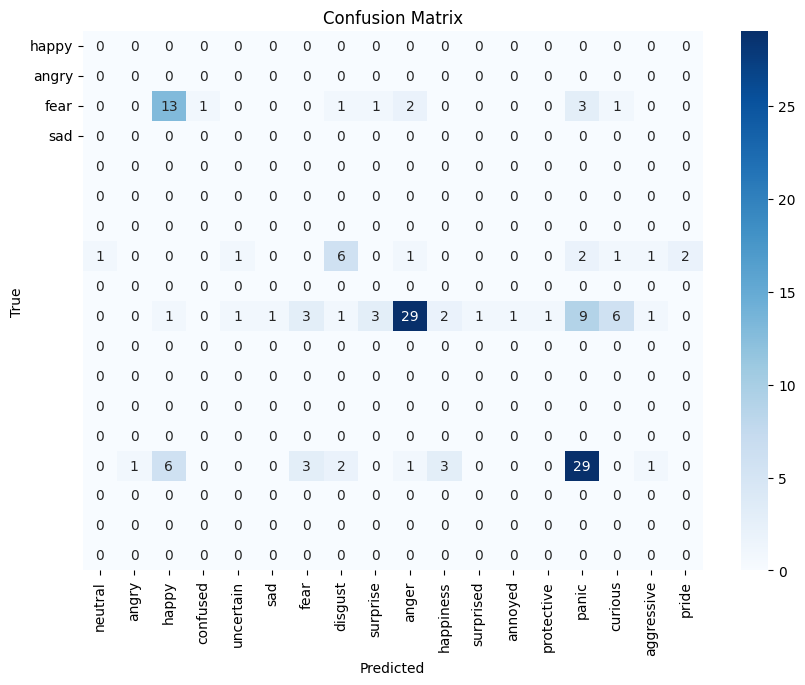

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns


# Print classification report
print(classification_report(df_sample['emotion'], df_sample['predicted_emotion']))#, target_names=recognizer.emotions))

# Generate confusion matrix
cm = confusion_matrix(df_sample['emotion'], df_sample['predicted_emotion'])
# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=df_sample['predicted_emotion'].unique(), yticklabels=df_sample['emotion'].unique())
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()  
# 7 nulls 54%

### qwen

              precision    recall  f1-score   support

    "happy".       0.00      0.00      0.00         0
      Happy.       0.00      0.00      0.00         0
     Neutral       0.00      0.00      0.00         0
    Neutral.       0.00      0.00      0.00         0
        Sad.       0.00      0.00      0.00         0
      amused       0.00      0.00      0.00         0
       angry       1.00      0.14      0.24        22
     annoyed       0.00      0.00      0.00         0
     anxious       0.00      0.00      0.00         0
       bacon       0.00      0.00      0.00         0
     blessed       0.00      0.00      0.00         0
      boring       0.00      0.00      0.00         0
        busy       0.00      0.00      0.00         0
        cold       0.00      0.00      0.00         0
       cool.       0.00      0.00      0.00         0
     damaged       0.00      0.00      0.00         0
    defeated       0.00      0.00      0.00         0
  delighted.       0.00    

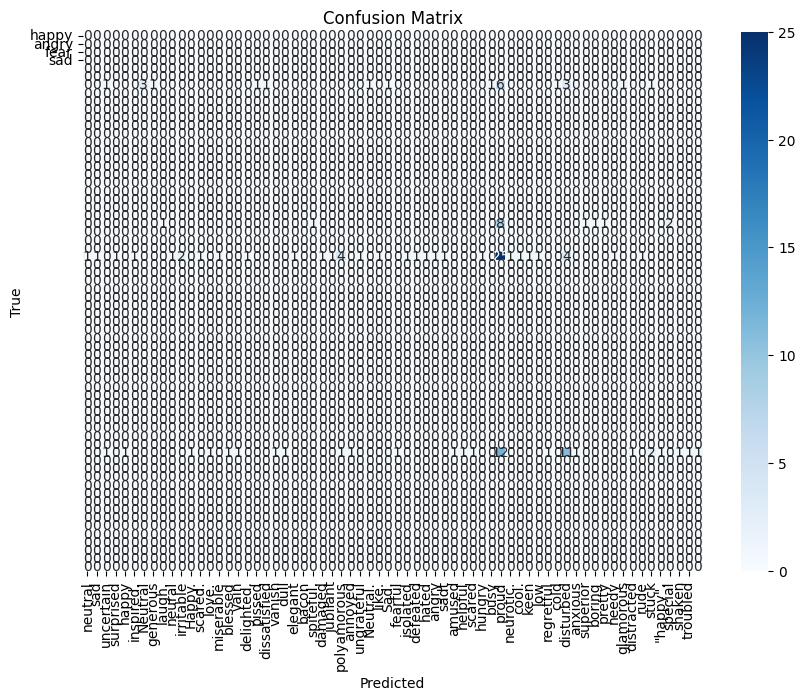

In [21]:

# Print classification report
print(classification_report(df_sample['emotion'], df_sample['predicted_emotion']))#, target_names=recognizer.emotions))

# Generate confusion matrix
cm = confusion_matrix(df_sample['emotion'], df_sample['predicted_emotion'])
# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=df_sample['predicted_emotion'].unique(), yticklabels=df_sample['emotion'].unique())
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()  


Let's design your Textual Emotion Recognition (TER) and Text Sentiment Analysis (TSA) experiments, keeping in mind your previous attempts with LLM prompting. We'll focus on more traditional ML and DL approaches based on your suggestions.

**Addressing LLM Prompting (Briefly):**

Your experience with prompting LLMs to classify text into emotions is a valid approach. For these 16 experiments, however, we'll concentrate on more explicit feature extraction and modeling techniques. You can always compare the performance of these traditional methods with your LLM-based results later. Regarding classifying full text vs. parts, both have their merits. Analyzing parts might capture nuanced shifts in emotion within a text, while full text analysis provides a holistic view. For these experiments, let's initially focus on classifying the *full text*.

**Designing the 16 Experiments:**

Here's a potential breakdown of your 16 experiments for TER/TSA:

**Feature Extraction (Choose 2 Options):**

1.  **Bag-of-Words (BoW) with TF-IDF Weighting:**
    * **Explanation:** This traditional method represents text as a collection of its words, disregarding grammar and word order but keeping track of word frequencies. TF-IDF (Term Frequency-Inverse Document Frequency) weighs words based on their frequency in a document and their rarity across the entire corpus, highlighting important terms.
    * **Implementation:** Use `sklearn.feature_extraction.text.TfidfVectorizer`.

2.  **Word Embeddings (Pre-trained GloVe or Word2Vec):**
    * **Explanation:** Word embeddings represent words as dense vectors in a continuous vector space, capturing semantic relationships between words. Pre-trained embeddings like GloVe or Word2Vec, trained on large corpora, can provide a good starting point. For a single text, you might average the embeddings of all its words to get a fixed-size vector representation.
    * **Implementation:** Use libraries like `gensim` to load pre-trained embeddings and then average the embeddings of the words in each text sample. For words not in the vocabulary, you'll need a strategy (e.g., ignore, use a zero vector).

**Feature Selection (Choose 2 Options):**

1.  **No Feature Selection:** Use all the features extracted in the previous step directly as input to the models.
2.  **SelectKBest with Chi-squared (for BoW/TF-IDF):**
    * **Explanation:** Chi-squared is a statistical test that measures the dependence between categorical variables. In text classification, it can be used to select the features (words/n-grams) that are most strongly associated with each emotion class.
    * **Implementation:** Use `sklearn.feature_selection.SelectKBest` with `score_func=chi2`. You'll need to determine an appropriate value for `k` (the number of top features to select) through experimentation or cross-validation.
3.  **Principal Component Analysis (PCA) for Dimensionality Reduction (for Word Embeddings):**
    * **Explanation:** PCA is a dimensionality reduction technique that finds the principal components (directions of maximum variance) in your data. By projecting your word embedding-based feature vectors onto a lower-dimensional subspace defined by the top principal components, you can reduce noise and computational cost while retaining most of the important information.
    * **Implementation:** Use `sklearn.decomposition.PCA` and choose the number of components to keep (e.g., based on explained variance).

**Evaluation Strategy (Choose 2 Options):**

1.  **Hold-Out Validation (70% Train, 30% Test):** Split your dataset into a training set (70%) for model training and a separate, unseen test set (30%) for final performance evaluation.
2.  **5-Fold Stratified Cross-Validation:** Divide your dataset into 5 folds, ensuring each fold maintains the original class proportions. Train your model on 4 folds and evaluate it on the remaining fold. Repeat this 5 times, using each fold as the evaluation set once. The final performance is the average across the 5 folds.

**Modeling Approach (Choose 2 Options):**

1.  **Traditional ML (SVM with Linear Kernel):**
    * **Explanation:** Support Vector Machines with a linear kernel are effective for high-dimensional text data. They aim to find the optimal hyperplane that separates the different emotion classes in the feature space.
    * **Implementation:** Use `sklearn.svm.SVC` with `kernel='linear'`. You might want to tune the regularization parameter `C` using cross-validation on your training data.

2.  **Traditional DL (1D CNN):**
    * **Explanation:** 1D Convolutional Neural Networks can learn local patterns in sequential data like text. Each word embedding can be considered a feature at a specific time step. Convolutional filters can slide over these embeddings to capture n-gram-like features and their relationships.
    * **Implementation:** Use TensorFlow/Keras or PyTorch to build a 1D CNN. You'll need an embedding layer (which can be initialized with your pre-trained word embeddings or learned from scratch), followed by convolutional layers, pooling layers, and fully connected layers for classification.

**The 16 Experiments:**

Here's a table outlining the 16 possible combinations:

| Experiment | Feature Extraction          | Feature Selection                  | Evaluation Strategy         | Modeling Approach         |
| :--------- | :-------------------------- | :--------------------------------- | :-------------------------- | :-------------------------- |
| 1          | BoW with TF-IDF             | None                               | Hold-Out Validation         | SVM (Linear)              |
| 2          | BoW with TF-IDF             | None                               | Hold-Out Validation         | 1D CNN                    |
| 3          | BoW with TF-IDF             | None                               | 5-Fold Cross-Validation     | SVM (Linear)              |
| 4          | BoW with TF-IDF             | None                               | 5-Fold Cross-Validation     | 1D CNN                    |
| 5          | BoW with TF-IDF             | SelectKBest (Chi2)               | Hold-Out Validation         | SVM (Linear)              |
| 6          | BoW with TF-IDF             | SelectKBest (Chi2)               | Hold-Out Validation         | 1D CNN                    |
| 7          | BoW with TF-IDF             | SelectKBest (Chi2)               | 5-Fold Cross-Validation     | SVM (Linear)              |
| 8          | BoW with TF-IDF             | SelectKBest (Chi2)               | 5-Fold Cross-Validation     | 1D CNN                    |
| 9          | Word Embeddings (Pre-trained) | None                               | Hold-Out Validation         | SVM (Linear)              |
| 10         | Word Embeddings (Pre-trained) | None                               | Hold-Out Validation         | 1D CNN                    |
| 11         | Word Embeddings (Pre-trained) | None                               | 5-Fold Cross-Validation     | SVM (Linear)              |
| 12         | Word Embeddings (Pre-trained) | None                               | 5-Fold Cross-Validation     | 1D CNN                    |
| 13         | Word Embeddings (Pre-trained) | PCA                                | Hold-Out Validation         | SVM (Linear)              |
| 14         | Word Embeddings (Pre-trained) | PCA                                | Hold-Out Validation         | 1D CNN                    |
| 15         | Word Embeddings (Pre-trained) | PCA                                | 5-Fold Cross-Validation     | SVM (Linear)              |
| 16         | Word Embeddings (Pre-trained) | PCA                                | 5-Fold Cross-Validation     | 1D CNN                    |

**Implementation Details and Considerations:**

* **Dataset Preparation:** You'll need a labeled text dataset for emotion recognition (e.g., GoEmotions, SemEval datasets). Preprocess the text data (e.g., lowercasing, removing punctuation, tokenization).
* **Word Embedding Handling:** For the word embedding approach, you'll need to load the pre-trained embeddings and create a vocabulary mapping from your dataset's words to the embedding vectors. Handle out-of-vocabulary words appropriately. When feeding into the 1D CNN, you'll need to create sequences of word indices and potentially pad them to a fixed length.
* **1D CNN Architecture:** Experiment with different numbers of filters, kernel sizes, activation functions, pooling layers, and the embedding layer's properties (trainable or non-trainable).
* **Hyperparameter Tuning:** For both SVM and 1D CNN, you'll likely need to tune hyperparameters using cross-validation on your training data to achieve optimal performance.
* **Evaluation Metrics:** Use appropriate evaluation metrics for multi-class classification, such as accuracy, precision, recall, F1-score (macro and weighted averages), and confusion matrices.

By systematically conducting these experiments, you can gain insights into the effectiveness of different text representation techniques, the impact of feature selection, the robustness of your evaluation strategy, and the performance of traditional linear models versus a basic deep learning architecture for your text-based emotion recognition task. Remember to document your findings for each experiment.